<a href="https://colab.research.google.com/github/shell769324/NILBIE/blob/main/where_mask/MMML_combined_mask.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget 'https://raw.githubusercontent.com/shell769324/NILBIE/main/where_mask/images/cube.png'

--2020-12-11 19:27:49--  https://raw.githubusercontent.com/shell769324/NILBIE/main/where_mask/images/cube.png
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 229 [image/png]
Saving to: ‘cube.png’

cube.png            100%[===================>]     229  --.-KB/s    in 0s      

2020-12-11 19:27:49 (8.87 MB/s) - ‘cube.png’ saved [229/229]



In [7]:
# Mount your Drive and Move required Files
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
%%capture
!tar -xvf '/content/drive/My Drive/SSCR_dataset/emnlp20_sscr/data/dataset.tar.gz'

#WHAT MASK

In [10]:
import urllib.request
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
import h5py
import cv2
from PIL import Image
import numpy as np
import re
import collections

In [12]:
try:
  urllib.request.urlretrieve('https://raw.githubusercontent.com/shell769324/NILBIE/main/where_mask/images/cube.png', "cube.png")
  urllib.request.urlretrieve('https://raw.githubusercontent.com/shell769324/NILBIE/main/where_mask/images/sphere.png', "sphere.png")
  urllib.request.urlretrieve('https://raw.githubusercontent.com/shell769324/NILBIE/main/where_mask/images/cylinder.png', "cylinder.png")
  urllib.request.urlretrieve('https://raw.githubusercontent.com/shell769324/NILBIE/main/where_mask/images/objects.txt', "objects.txt")
except:
  print('Could not download images for generating Masks for grey objects')

In [35]:
fobjects = open("objects.txt", "r").readlines()
object_list = [i.strip('\n') for i in fobjects]
list_color_shape = [val.split(' ')[1]+' '+val.split(' ')[0] for val in object_list]

In [36]:
def create_sample_mask(img):
  img = img[:,:, 2]
  R = len(img)
  C = len(img[0])
  # print(R, C)
  mask = [[0]*C for _ in range(R)]
  for i in range(R):
    for j in range(C):
      if img[i][j] == 255:
        mask[i][j] = 1

  return mask

In [56]:
gen_masks_shape = {}

img_cube = cv2.imread('cube.png')
img_sphere = cv2.imread('sphere.png')
img_cylinder = cv2.imread('cylinder.png')

gen_mask_cube = create_sample_mask(img_cube)
gen_mask_sphere = create_sample_mask(img_sphere)
gen_mask_cylinder = create_sample_mask(img_cylinder)

dim = (20,20)
dim_cyl = (10,20)

# resize image
resized_sphere = cv2.resize(img_sphere, dim, interpolation = cv2.INTER_AREA)
gen_masks_shape['sphere'] = resized_sphere[:,:,2]

resized_cube = cv2.resize(img_cube, dim, interpolation = cv2.INTER_AREA)
gen_masks_shape['cube'] = resized_cube[:,:,2]

resized_cyl = cv2.resize(img_cylinder, dim_cyl, interpolation = cv2.INTER_AREA)
gen_masks_shape['cylinder'] = resized_cyl[:,:,2]

In [57]:
color_thres_dict = {"red":10, "yellow":10, "brown":10,
                   "cyan":10, "green":10, "blue":10,
                    "purple":50, 'gray':10}

color_mean_dict = {"gray": [87, 87, 87],
                    "red": [173, 35, 35],
                    "blue": [42, 75, 215],
                    "green": [29, 105, 20],
                    "brown": [129, 74, 25],
                    "purple": [129, 38, 192],
                    "cyan": [41, 208, 208],
                    "yellow": [255, 238, 51]}

In [58]:
def rgb2hsv(color_string):
    [red, green, blue] = color_mean_dict[color_string]
    thres = color_thres_dict[color_string]
    
    color = np.uint8([[[blue, green, red]]])
    hsv_color = cv2.cvtColor(color, cv2.COLOR_BGR2HSV)
    hue = hsv_color[0][0][0]
    
    low = max(0, hue - thres)
    high = min(360, hue + thres)
    lower_range = np.array([low, 50, 50], dtype=np.uint8)
    upper_range = np.array([high, 255, 255], dtype=np.uint8)
    
    return lower_range, upper_range

In [59]:
def color_detect(img, color="red"):
    hsv_img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    # low, high = rgb2hsv(237, 28, 36)
    low, high = rgb2hsv(color)
    # print(low, high)
    mask = cv2.inRange(hsv_img, low, high)  
    return mask, img

In [60]:
def get_next_object(objects, dicts):
  idxs = [i for i,v in enumerate(objects) if v == 1]
  for i in idxs:
    if i not in dicts:
      dicts[i] = 1
      return i

In [61]:
def sanitize_mask(orig_x, orig_y, mask):
  """
  Given a mask return the mask of only one object
  """
  contours, hierarchy = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

  # Draw contours:
  cv2.drawContours(mask, contours, 0, (0, 255, 0), 2)
  # Calculate image moments of the detected contour
  num_objects = (len(contours))
  #threshold
  threshold = 3

  center_list = []
  # print(num_objects)
  if num_objects > 1:
    for item in range(num_objects):
      M = cv2.moments(contours[item])
      try:
        center_x = round(M['m10'] / M['m00'])
        center_y = round(M['m01'] / M['m00'])
        center_list.append([center_y , center_x ])
      except:
        pass

  # initialize retmask
  retmask = mask
  if num_objects > 1:
    for x, y in center_list:
      if orig_x - threshold <= x <= orig_x + threshold and orig_y - threshold <= y <= orig_y + threshold:
        pass
      else:
        def dfs_removal(px , py, mask):
            R = len(mask)
            C = len(mask[0])
            if mask[px][py ] != 255: 
              return
            mask[px][py] = 0
            if 0 <= px - 1 and mask[px - 1][py ] == 255:  dfs_removal(px - 1 , py , mask)
            if  px + 1 < R and mask[px + 1][py ] == 255:  dfs_removal(px + 1 , py , mask)
            if 0 <= py - 1  and mask[px][py - 1] == 255:  dfs_removal(px, py -1 , mask)
            if py + 1 < C and mask[px][py + 1] == 255:  dfs_removal(px, py + 1 , mask)

        dfs_removal(x,y, mask)

  return retmask

In [62]:
def gray_region(x,y,shape,original_mask):
  overlay = gen_masks_shape[shape]
  x_offset=50
  y_offset=30
  original_mask[y_offset:y_offset + overlay.shape[0], x_offset:x_offset+ overlay.shape[1]] = overlay
  return original_mask

In [63]:
def get_dict(dicts, coords, objects):
  """
  return the coordinate of the newly added object
  """
  o_idx = [i for i, x in enumerate(objects) if x == 1]
  # print(o_idx)
  # print(dicts)
  for idx in o_idx:
    if idx not in dicts:
      dicts[idx] = coords[idx]
      return coords[idx]

In [64]:
def create_grid(x, y, startx, endx, starty, endy):  
  grid = [[0]*x for _ in range(y)]
  for i in range(startx, endx):
    for j in range(starty , endy):
      grid[j][i]= 1
  return grid

In [65]:
def tune_mask(ret):
  masks = []
  for item in ret:
    x, y, bf, lr = item
    if bf == -1 and lr == -1:
      startx, endx, starty, endy = 0, x, 0, y
    elif bf == 1 and lr == -1:
      startx, endx, starty, endy = 0, x, y, MASK_SIZE
    elif bf == -1 and lr == 1:
      startx, endx, starty, endy = x,MASK_SIZE, 0,y
    elif bf == 1 and lr == 1:
      startx, endx, starty, endy = x, MASK_SIZE, y, MASK_SIZE
    mask = create_grid(MASK_SIZE, MASK_SIZE, int(startx), int(endx), int(starty), int(endy))
    masks.append(mask)

  if len(masks)==1:
    return masks[0]

  final_mask = [[0]*MASK_SIZE for _ in range(MASK_SIZE)]

  for i in range(MASK_SIZE):
    for j in range(MASK_SIZE):
      if masks[0][i][j] == masks[1][i][j]==1:
        final_mask[i][j] = 1

  return final_mask

In [66]:
def get_objects_xy(ctext,object_track_list,last_object,object_added_color_shape):
  ret = []
  lr,bf = 1,1
  if 'and' in ctext:
    first_, secd_ = ctext.split('and')
    for lang in [first_, secd_]:
      if 'right' in lang:
        lr = 1
      elif 'left' in lang:
        lr = -1
      if 'front' in lang:
        bf = 1
      elif 'behind' in lang:
        bf = -1
      if 'it' not in lang:
        for object_name in list_color_shape:
          if object_name in lang and object_name != object_added_color_shape:
            ocolor, oshape  = object_name.split(' ')
            ox, oy = object_track_list[ocolor, oshape]
            ret.append([ox, oy, bf, lr])

      elif 'it' in lang:
        itx, ity = object_track_list[last_object[0],last_object[1]]
        ret.append([itx, ity, bf, lr])

  elif 'it' in ctext:
    if 'right' in ctext:
      lr = 1
    elif 'left' in ctext:
      lr = -1
    if 'front' in ctext:
      bf = 1
    elif 'behind' in ctext:
      bf = -1
    itx, ity = object_track_list[last_object[0],last_object[1]]
    ret.append([itx, ity, bf, lr])


  return ret

In [68]:
destination_path = 'clevr_train_with_mask.h5'
original_path = '/content/GeNeVA_datasets/data/iCLEVR/clevr_train.h5'

fs = h5py.File(original_path, 'r')
fd = h5py.File(destination_path, 'w')

def get_num_keys(destination_path):
  #returns number of datasets in h5py
  fcheck = h5py.File(destination_path, 'r')
  return len(fcheck.keys())

#get number of datasets in h5py file
batch_size_copy = get_num_keys(original_path) -2

for i in range(batch_size_copy):
  xid = f'{i:06d}'
  fs.copy(xid,fd)

fs.copy('background', fd)
fs.copy('entities', fd)
fs.close()
fd.close()

In [69]:
MASK_SIZE = 128
fdest = h5py.File(destination_path, 'r+')
num_keys_in_destination = get_num_keys(destination_path) - 2
for i in range(num_keys_in_destination):
  xid = f'{i:06d}'
  # print(xid,'/', num_keys_in_destination)

  txt_values = fdest[xid]['text'].value.split(',')
  object_vals = fdest[xid]['objects']
  coords_vals = fdest[xid]['coords']
  image_vals = fdest[xid]['images']
  object_dict = {}
  object_track_list = {}

  what_mask = []
  where_mask = []
  last_object = ''

  for i in range(5):
    image_resized = image_vals[i] 
    object_added = get_next_object(object_vals[i], object_dict)
    color_added = object_list[object_added].split(' ')[-1]
    shape_added = object_list[object_added].split(' ')[0]
    # get shape centre
    x_coord, y_coord, _ = coords_vals[i][object_added]
    mask, img = color_detect(image_resized, color_added)
    if color_added != 'gray':
      mask = sanitize_mask(y_coord, x_coord, mask)
    elif color_added == 'gray':
      mask = np.array([[0]*MASK_SIZE for _ in range(MASK_SIZE)])
      mask = gray_region(y_coord, x_coord, shape_added, mask)
    what_mask.append(mask)

    #WHERE MASK
    # new_grid = [[0]*MASK_SIZE for _ in range(MASK_SIZE)]
    ctext = txt_values[i].replace('[','').replace(']','').replace('"','')
    # object_added = get_next_object(object_vals[i], object_dict)
    # color_added = object_list[object_added].split(' ')[-1]
    # shape_added = object_list[object_added].split(' ')[0]
    object_added_color_shape = color_added + ' ' + shape_added
    new_grid = [[1]*MASK_SIZE for _ in range(MASK_SIZE)]

    if i > 0:
      ret = get_objects_xy(ctext, object_track_list, last_object, object_added_color_shape)
      new_grid = tune_mask(ret)

    where_mask.append(new_grid)
    
    # get shape centre
    last_object = [color_added, shape_added]
    object_track_list[color_added, shape_added]=[x_coord ,y_coord]

  fdest[xid].create_dataset('what', data = np.array(what_mask))  
  fdest[xid].create_dataset('where', data = np.array(where_mask))

fdest.close()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  


<KeysViewHDF5 ['coords', 'images', 'objects', 'scene_id', 'text', 'what', 'where']>
<HDF5 dataset "what": shape (5, 128, 128), type "|u1">


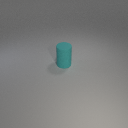

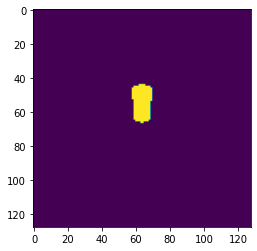

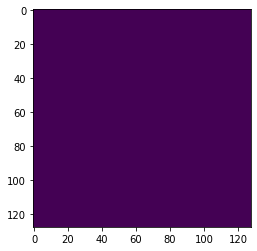

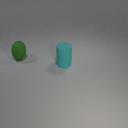

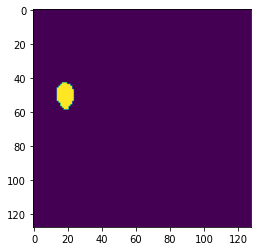

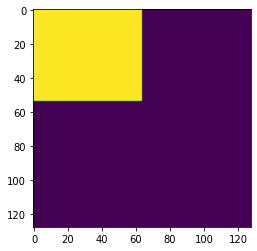

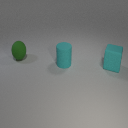

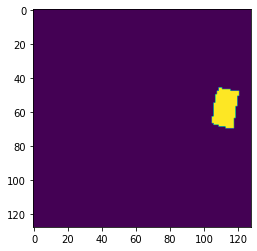

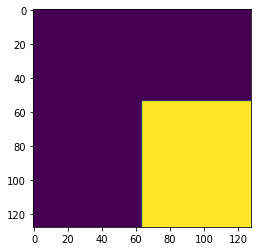

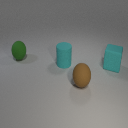

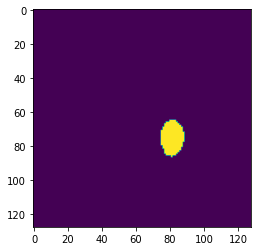

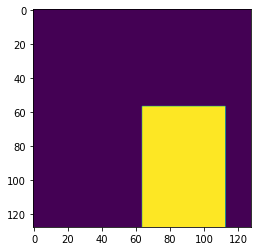

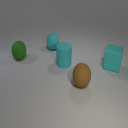

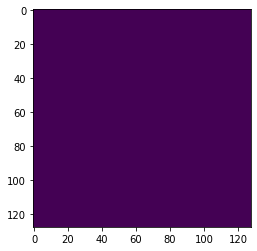

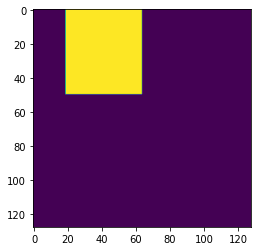

<KeysViewHDF5 ['coords', 'images', 'objects', 'scene_id', 'text', 'what', 'where']>
<HDF5 dataset "what": shape (5, 128, 128), type "<i8">


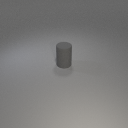

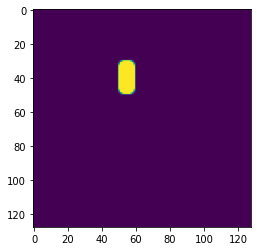

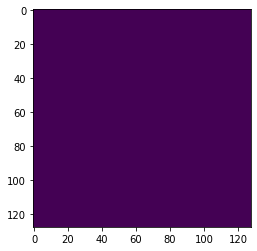

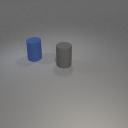

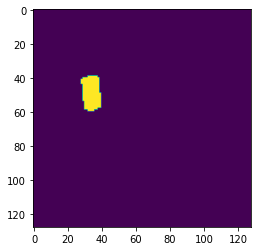

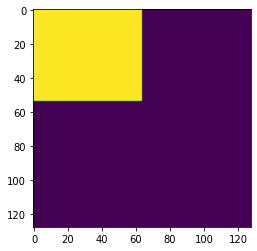

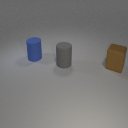

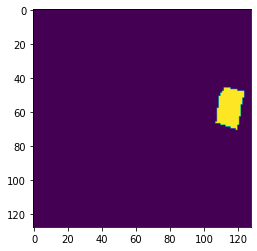

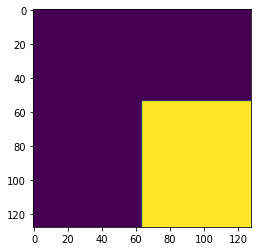

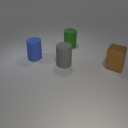

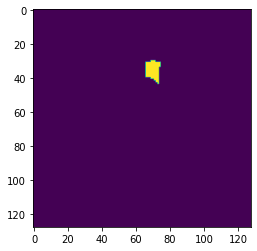

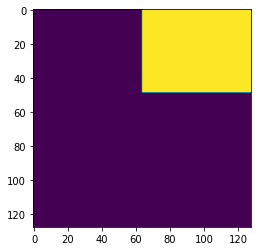

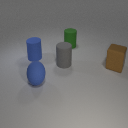

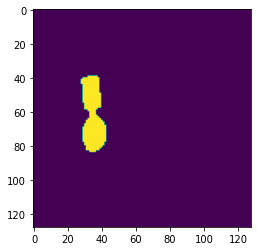

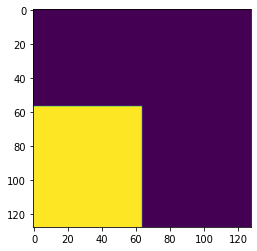

<KeysViewHDF5 ['coords', 'images', 'objects', 'scene_id', 'text', 'what', 'where']>
<HDF5 dataset "what": shape (5, 128, 128), type "<i8">


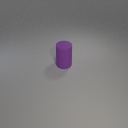

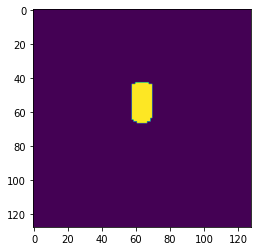

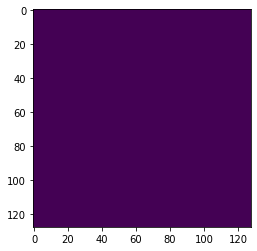

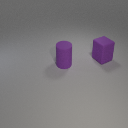

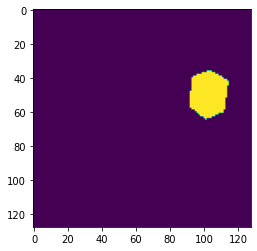

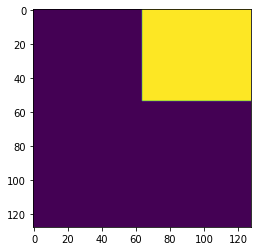

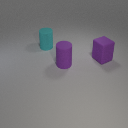

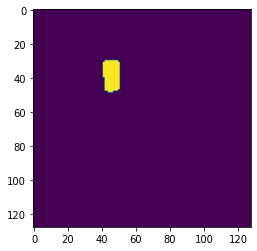

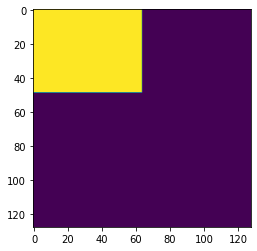

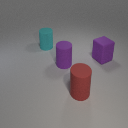

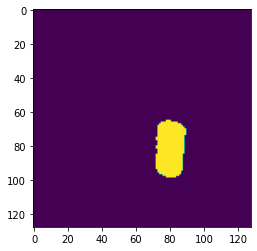

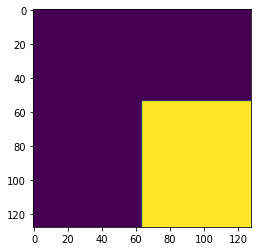

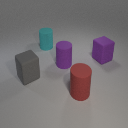

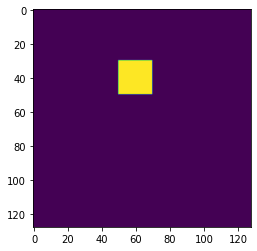

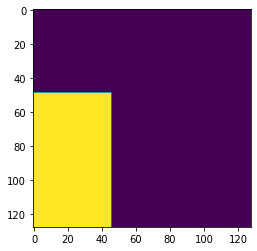

In [70]:
import h5py
check_path = destination_path
fcheck = h5py.File(check_path, 'r')
check_nums = 3
from google.colab.patches import cv2_imshow
for i in range(check_nums):
  xid = f'{i:06d}'
  print(fcheck[xid].keys())
  print(fcheck[xid]['what'])
  for i in range(5):
    actual_img = fcheck[xid]['images'][i]
    cv2_imshow(actual_img)
    mask_grid = fcheck[xid]['what'][i]
    plt.imshow(mask_grid)
    plt.show()
    mask_where= fcheck[xid]['where'][i]
    plt.imshow(mask_where)
    plt.show()